In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import mkl

mkl.set_num_threads(4)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [3]:
def append_ones(matrix, axis=1):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def randn(*dims):
    return np.random.randn(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def as_matrix(vector):
    return np.reshape(vector, (-1, 1))

def one_hot_encode(labels):
    one_hot = zeros(labels.shape[0], np.max(labels) + 1) 
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)

def classify(mlp, batch):
    probabilities, _ = forward_pass(mlp, batch, False)
    return np.argmax(probabilities, axis=1)

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

def draw_layer_filters(layer):
    filters = np.reshape(layer.W[:-1].T, newshape=(16, -1, 28, 28))
    tiles(filters)

### Activation functions

In [4]:
def sigmoid(batch, stochastic=False):
    activations = 1.0 / (1.0 + np.exp(-batch))
    if stochastic:
        return activations > rand(*activations.shape).astype(np.float32)
    else:
        return activations

def sigmoid_derivative(batch):
    s = sigmoid(batch)
    return s * (1.0 - s)

def softmax(batch):
    # Softmax activation function
    maxes = np.max(batch, axis=1)
    reduced_batch = batch - maxes.reshape([-1, 1])
    exps = np.exp(reduced_batch)
    sums = np.sum(exps, axis=1).reshape([-1, 1])
    return exps / sums

In [5]:
def relu(batch, stochastic=False):
    if stochastic:
        noised_batch = batch + np.random.normal(0, sigmoid(batch))
        activations = np.maximum(0, noised_batch)
    else:
        activations = np.maximum(0, batch)       
        
    return activations

def relu_derivative(batch):
    return (batch > 0).astype(np.float)

# MNIST dataset

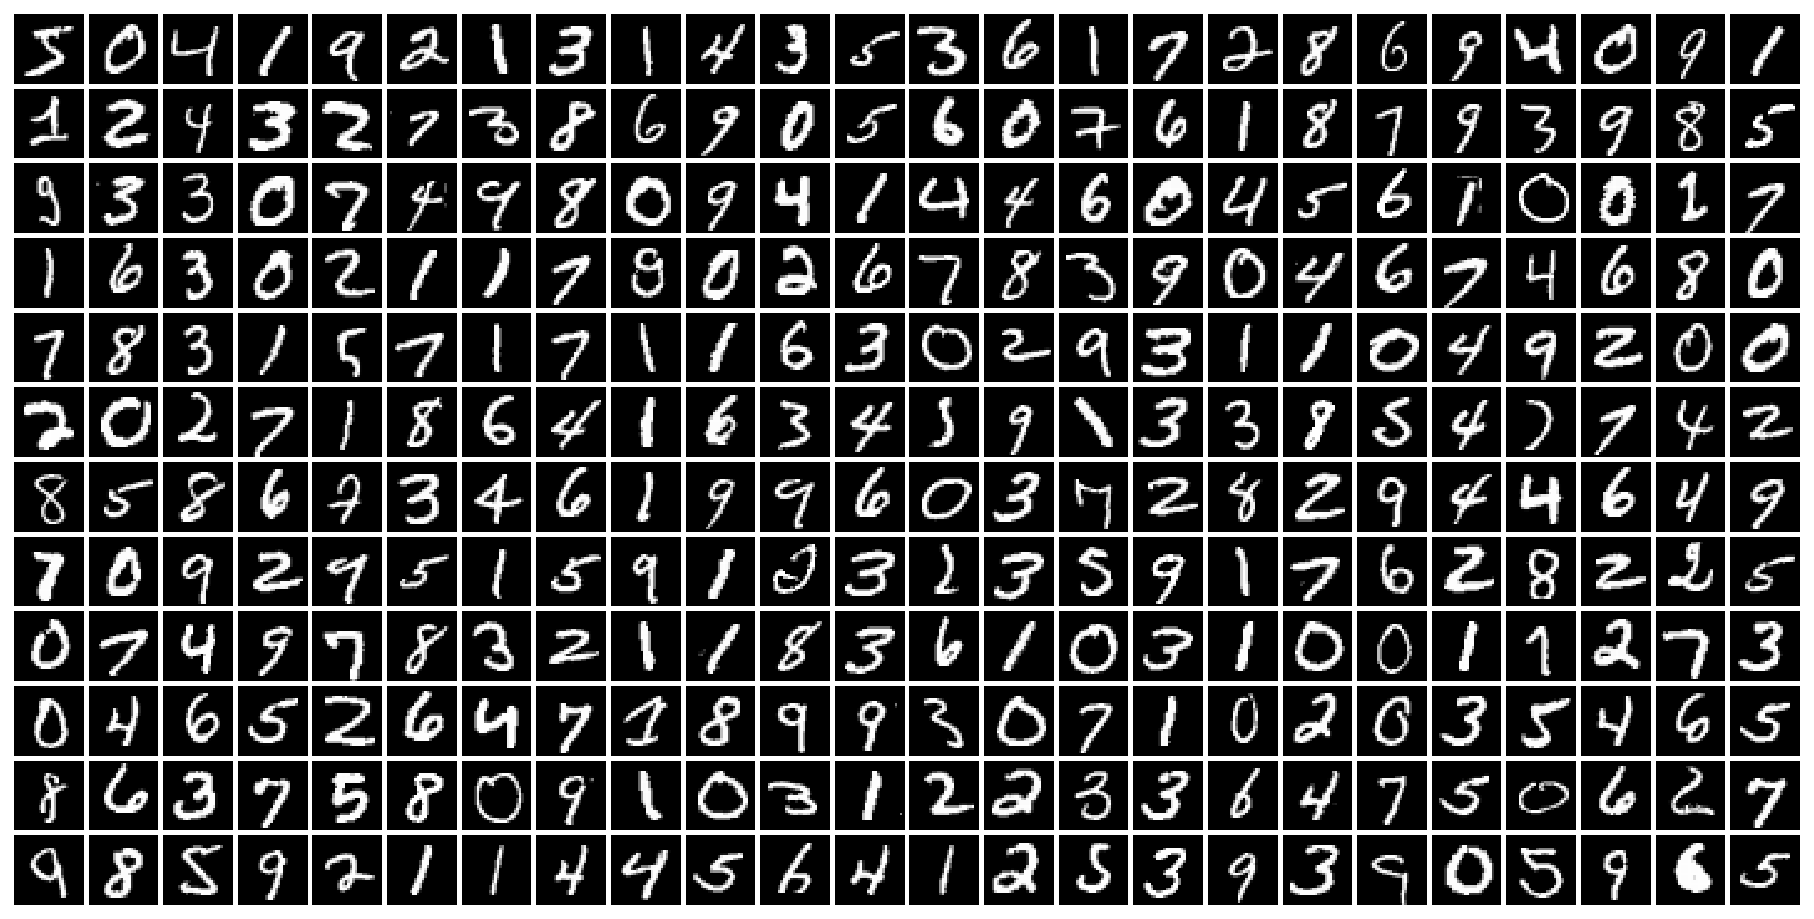

In [6]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# MLP training

In [7]:
class Layer:
    def __init__(self, visible_size, hidden_size, activation_fun, d_activation_fun, 
                 dropout_rate, learning_rate, momentum, weight_limit):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        
        self.activation_fun = activation_fun
        self.d_activation_fun = d_activation_fun
        
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.weight_limit = weight_limit
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size)).astype(np.float32)
        self.W[-1, :] = 0.0
        
        self.activations = None
        self.d_activations = None
        self.deltas = None
        
        self.M = zeros(self.visible_size+1, self.hidden_size)
        
    def deep_copy(self):
        copy = Layer(self.visible_size, self.hidden_size, self.activation_fun, self.d_activation_fun,
                     self.dropout_rate, self.learning_rate, self.momentum, self.weight_limit)
        copy.W = np.copy(self.W)
        copy.M = np.copy(self.M)
        return copy

In [8]:
def limit_weights(weights, limit):
    # limit the length of each neuron's weights vector
    norms = np.linalg.norm(weights, axis=0)
    weights_to_limit = norms > limit
    
    new_weights = weights.copy()
    new_weights[:, weights_to_limit] = new_weights[:, weights_to_limit] / norms[weights_to_limit] * limit
    
    return new_weights

### Forward pass

Calculate total input to the neurons. Then calculate activations (remember to add *ones* as the last column). Store result in `layer.activations`.

##### Computing derivatives of activation function

If `compute_derivatives` is set to `True`, we also need to compute the derivatives of the activation function and store them in `layer.d_activations`. We **do not** need to add *ones column* to the derivatives matrix! *Ones* are only needed in the activations matrix, where they are used to add biases to the total input of neurons in the next hidden layer.

##### Dropout

If `compute_derivatives` is set to `True` and the dropout rate in the input layer is greater than 0, we need to calculate the dropout mask for the MLP input and apply it to `batch`.

When calculating hidden activations in an MLP layer, check whether dropout rate in the next layer is greater then 0. If yes, then we need to apply dropout to the calculated activations (and derivatives of activations). In this case:
* construct dropout mask for the hidden layer,
* apply this mask to where it is needed in the hidden layer.

Do **not** apply dropout to the last column in activations or input batch, as they contains fixed *ones*.

In [9]:
def forward_pass(mlp, batch, compute_derivatives):    
    if compute_derivatives and mlp[0].dropout_rate > 0:
        batch = np.copy(batch)
        
        # apply dropout to the MLP input
        dropout_mask = np.random.rand(*batch.shape) > mlp[0].dropout_rate
        dropout_mask[:, -1] = 1
        batch = batch * dropout_mask
        
    visible = batch
    
    for layer_idx, layer in enumerate(mlp):
        # Compute layer activations
        z = visible @ layer.W
        layer.activations = append_ones(layer.activation_fun(z))
        
        if compute_derivatives and (layer_idx < len(mlp) - 1):
            # Compute derivatives of the activation function
            layer.d_activations = layer.d_activation_fun(z)
            
            if mlp[layer_idx+1].dropout_rate > 0:
                # apply dropout where is it needed in the hidden layer
                dropout_mask = np.random.rand(*layer.activations.shape) > mlp[layer_idx + 1].dropout_rate
                dropout_mask[:, -1] = 1
                layer.activations = layer.activations * dropout_mask
        
        visible = layer.activations
    
    return visible[:, :-1], batch

### Error backpropagation

In [10]:
def error_backpropagate(mlp, batch):
    observations_count = batch.shape[0]
        
    for layer_idx, layer in reversed(list(enumerate(mlp))):
        if layer_idx > 0:
            prev_layer = mlp[layer_idx - 1]
            visible = prev_layer.activations
            
            # Calculate the deltas in 'prev_layer'
            prev_layer.deltas = layer.deltas @ layer.W.T[:, :-1] * prev_layer.d_activations
        else:
            visible = batch
        
        # Update the momentum matrix with gradient from error backpropagation
        gradient = visible.T @ layer.deltas / observations_count
        layer.M = layer.momentum * layer.M - layer.learning_rate * gradient
        
        layer.W += layer.M
        
        if layer.weight_limit > 0.0:
            layer.W[:-1, :] = limit_weights(layer.W[:-1, :], layer.weight_limit)

### Mean dropout network

Implement the weight scalling for the network that approximates MLP outputs under dropout.

In [11]:
def mean_network(mlp):
    mlp = [layer.deep_copy() for layer in mlp]
    
    for layer in mlp:
        layer.W[:-1] = (1 - layer.dropout_rate) * layer.W[:-1]
    
    return mlp

### Training procedure

In [12]:
def train_mlp(mlp, dataset, labels, batch_size):
    batches_limit = dataset.shape[0] / batch_size
    
    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)
    
    for batch_idx, (batch, batch_labels) in enumerate(zip(batched_data, batched_labels)):
        # Forward pass: compute activatations and derivatives of activations
        y, batch_with_dropout = forward_pass(mlp, batch, True)
        
        # Delta in the sofmax layer
        mlp[-1].deltas = mlp[-1].activations[:, :-1] - batch_labels
        
        # Once softmax deltas are set, we may backpropagate errors
        error_backpropagate(mlp, batch_with_dropout)
        
        if batch_idx % round(batches_limit / 40) == 0: print("#", end="")

In [13]:
def run_mlp_training(mlp, train_set, train_labels, validation_set, validation_labels,
                     batch_size, epochs_count):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch+1),  end="\t")
        
        if epoch == 5:
            for layer in mlp:
                layer.momentum = 0.95
                layer.lr = 0.15
        elif epoch == 170:
            for layer in mlp:
                layer.momentum = 0.5
                layer.lr = 0.01
        
        start_time = time.time()
        train_mlp(mlp, train_set, train_labels, batch_size)
        elapsed = time.time() - start_time
        
        test_mlp = mean_network(mlp)
        
        predictions = classify(test_mlp, validation_set)
        accuracy = 100.0 * np.sum(predictions == validation_labels) / predictions.shape[0]
        print("\telapsed: {0:>2.2f}s, accuracy: {1:>2.2f}".format(elapsed, accuracy))

    print("Training finished!")

# MNIST digits classification

In [14]:
DATASET_SIZE = 5000 # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
mnist_train_images = append_ones(mnist_train_images)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = np.reshape(mnist_test_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))
mnist_test_images = append_ones(mnist_test_images)

mnist_test_labels = mnist.test_labels()

In [15]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 512

BATCH_SIZE = 128
EPOCHS_COUNT = 200

LEARNING_RATE = 0.03
SOFTMAX_LEARNING_RATE = 0.15
MOMENTUM = 0.5

In [16]:
from IPython.core.display import HTML

def evaluate(mlp, train_set, train_labels,
             validation_set, validation_labels,
             batch_size, epochs_count):
    for layer in mlp:
        layer.reset()

    display(HTML('<h3>MLP training</h3>'))
    run_mlp_training(mlp,
                     train_set, train_labels,
                     validation_set, validation_labels,
                     batch_size, epochs_count)
    
    display(HTML('<h3>Input layer filters in MLP</h3>'))
    draw_layer_filters(mlp[0])
    
    display(HTML('<h3>Largest norms of weight-vectors in MLP layers</h3>'))
    for i, layer in enumerate(mlp):
        max_norm = np.max(np.linalg.norm(layer.W[:-1, :], axis=0))
        print('\tlayer {0}: {1:.2f}'.format(i+1, max_norm))

### Plain MLP (no dropout)

Epoch 1:	########################################	elapsed: 0.66s, accuracy: 11.35
Epoch 2:	########################################	elapsed: 0.92s, accuracy: 20.59
Epoch 3:	########################################	elapsed: 0.61s, accuracy: 37.21
Epoch 4:	########################################	elapsed: 0.94s, accuracy: 59.92
Epoch 5:	########################################	elapsed: 0.61s, accuracy: 66.32
Epoch 6:	########################################	elapsed: 0.69s, accuracy: 80.28
Epoch 7:	########################################	elapsed: 0.70s, accuracy: 85.09
Epoch 8:	########################################	elapsed: 0.70s, accuracy: 88.99
Epoch 9:	########################################	elapsed: 0.69s, accuracy: 91.74
Epoch 10:	########################################	elapsed: 0.68s, accuracy: 93.49
Epoch 11:	########################################	elapsed: 0.69s, accuracy: 92.44
Epoch 12:	########################################	elapsed: 0.68s, accuracy: 93.77
Epoch 13:	###

Epoch 100:	########################################	elapsed: 0.69s, accuracy: 95.51
Epoch 101:	########################################	elapsed: 0.69s, accuracy: 95.51
Epoch 102:	########################################	elapsed: 0.67s, accuracy: 95.51
Epoch 103:	########################################	elapsed: 0.68s, accuracy: 95.51
Epoch 104:	########################################	elapsed: 0.68s, accuracy: 95.51
Epoch 105:	########################################	elapsed: 0.67s, accuracy: 95.51
Epoch 106:	########################################	elapsed: 0.68s, accuracy: 95.51
Epoch 107:	########################################	elapsed: 0.77s, accuracy: 95.51
Epoch 108:	########################################	elapsed: 0.68s, accuracy: 95.51
Epoch 109:	########################################	elapsed: 0.73s, accuracy: 95.51
Epoch 110:	########################################	elapsed: 0.68s, accuracy: 95.51
Epoch 111:	########################################	elapsed: 0.69s, accuracy

Epoch 197:	########################################	elapsed: 0.68s, accuracy: 95.52
Epoch 198:	########################################	elapsed: 0.68s, accuracy: 95.52
Epoch 199:	########################################	elapsed: 0.68s, accuracy: 95.52
Epoch 200:	########################################	elapsed: 0.68s, accuracy: 95.52
Training finished!


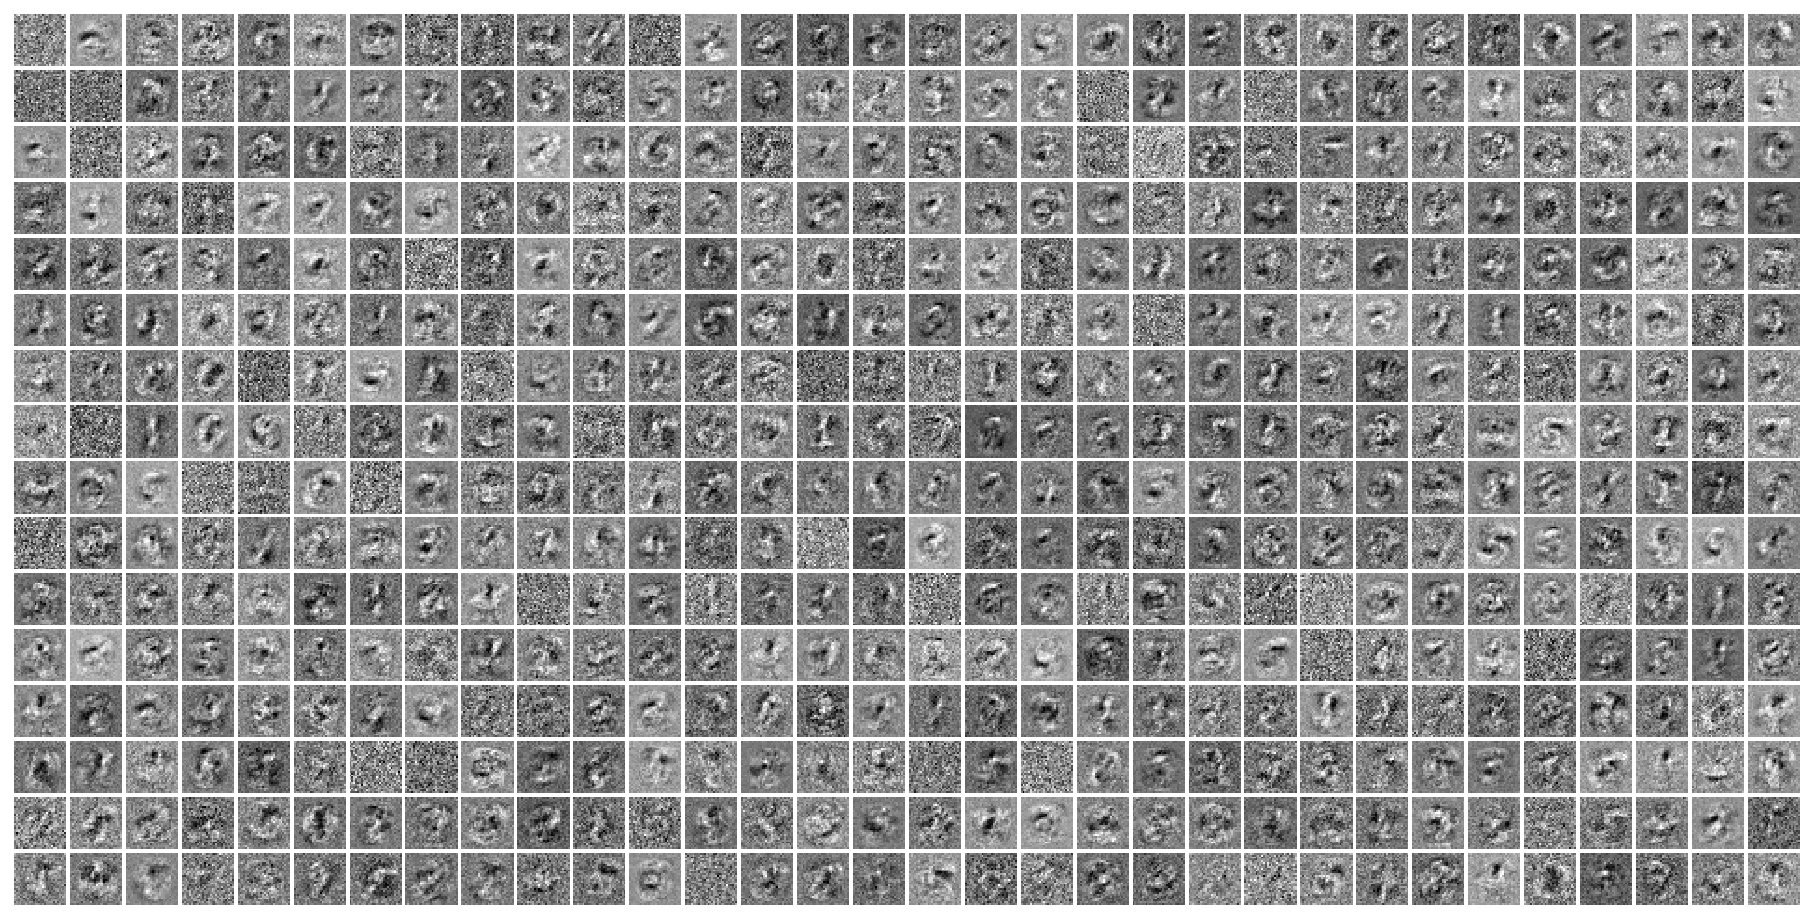

	layer 1: 1.00
	layer 2: 0.88
	layer 3: 4.00


In [17]:
mlp = [
    Layer(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.0, LEARNING_RATE, MOMENTUM,
          weight_limit=1.0),
    Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.0, LEARNING_RATE, MOMENTUM,
          weight_limit=1.0),
    Layer(HIDDEN_LAYER_SIZE, 10, softmax, None, 0.0, SOFTMAX_LEARNING_RATE, MOMENTUM,
          weight_limit=4.0)
]

evaluate(mlp, 
         mnist_train_images, mnist_train_labels, 
         mnist_test_images, mnist_test_labels,
         BATCH_SIZE, EPOCHS_COUNT)

### MLP with dropout

Epoch 1:	########################################	elapsed: 0.89s, accuracy: 11.35
Epoch 2:	########################################	elapsed: 0.79s, accuracy: 11.35
Epoch 3:	########################################	elapsed: 0.78s, accuracy: 11.35
Epoch 4:	########################################	elapsed: 0.78s, accuracy: 11.35
Epoch 5:	########################################	elapsed: 0.78s, accuracy: 11.35
Epoch 6:	########################################	elapsed: 0.77s, accuracy: 28.34
Epoch 7:	########################################	elapsed: 0.77s, accuracy: 62.05
Epoch 8:	########################################	elapsed: 0.78s, accuracy: 82.51
Epoch 9:	########################################	elapsed: 0.79s, accuracy: 86.69
Epoch 10:	########################################	elapsed: 0.80s, accuracy: 88.04
Epoch 11:	########################################	elapsed: 0.81s, accuracy: 89.73
Epoch 12:	########################################	elapsed: 0.84s, accuracy: 91.67
Epoch 13:	###

Epoch 100:	########################################	elapsed: 1.02s, accuracy: 95.31
Epoch 101:	########################################	elapsed: 1.00s, accuracy: 95.02
Epoch 102:	########################################	elapsed: 1.00s, accuracy: 95.15
Epoch 103:	########################################	elapsed: 1.01s, accuracy: 95.66
Epoch 104:	########################################	elapsed: 1.01s, accuracy: 95.12
Epoch 105:	########################################	elapsed: 1.01s, accuracy: 95.50
Epoch 106:	########################################	elapsed: 1.00s, accuracy: 94.95
Epoch 107:	########################################	elapsed: 1.01s, accuracy: 94.64
Epoch 108:	########################################	elapsed: 1.01s, accuracy: 94.81
Epoch 109:	########################################	elapsed: 1.01s, accuracy: 95.07
Epoch 110:	########################################	elapsed: 1.00s, accuracy: 95.28
Epoch 111:	########################################	elapsed: 1.00s, accuracy

Epoch 197:	########################################	elapsed: 0.88s, accuracy: 96.68
Epoch 198:	########################################	elapsed: 0.87s, accuracy: 96.80
Epoch 199:	########################################	elapsed: 0.88s, accuracy: 96.65
Epoch 200:	########################################	elapsed: 0.88s, accuracy: 96.77
Training finished!


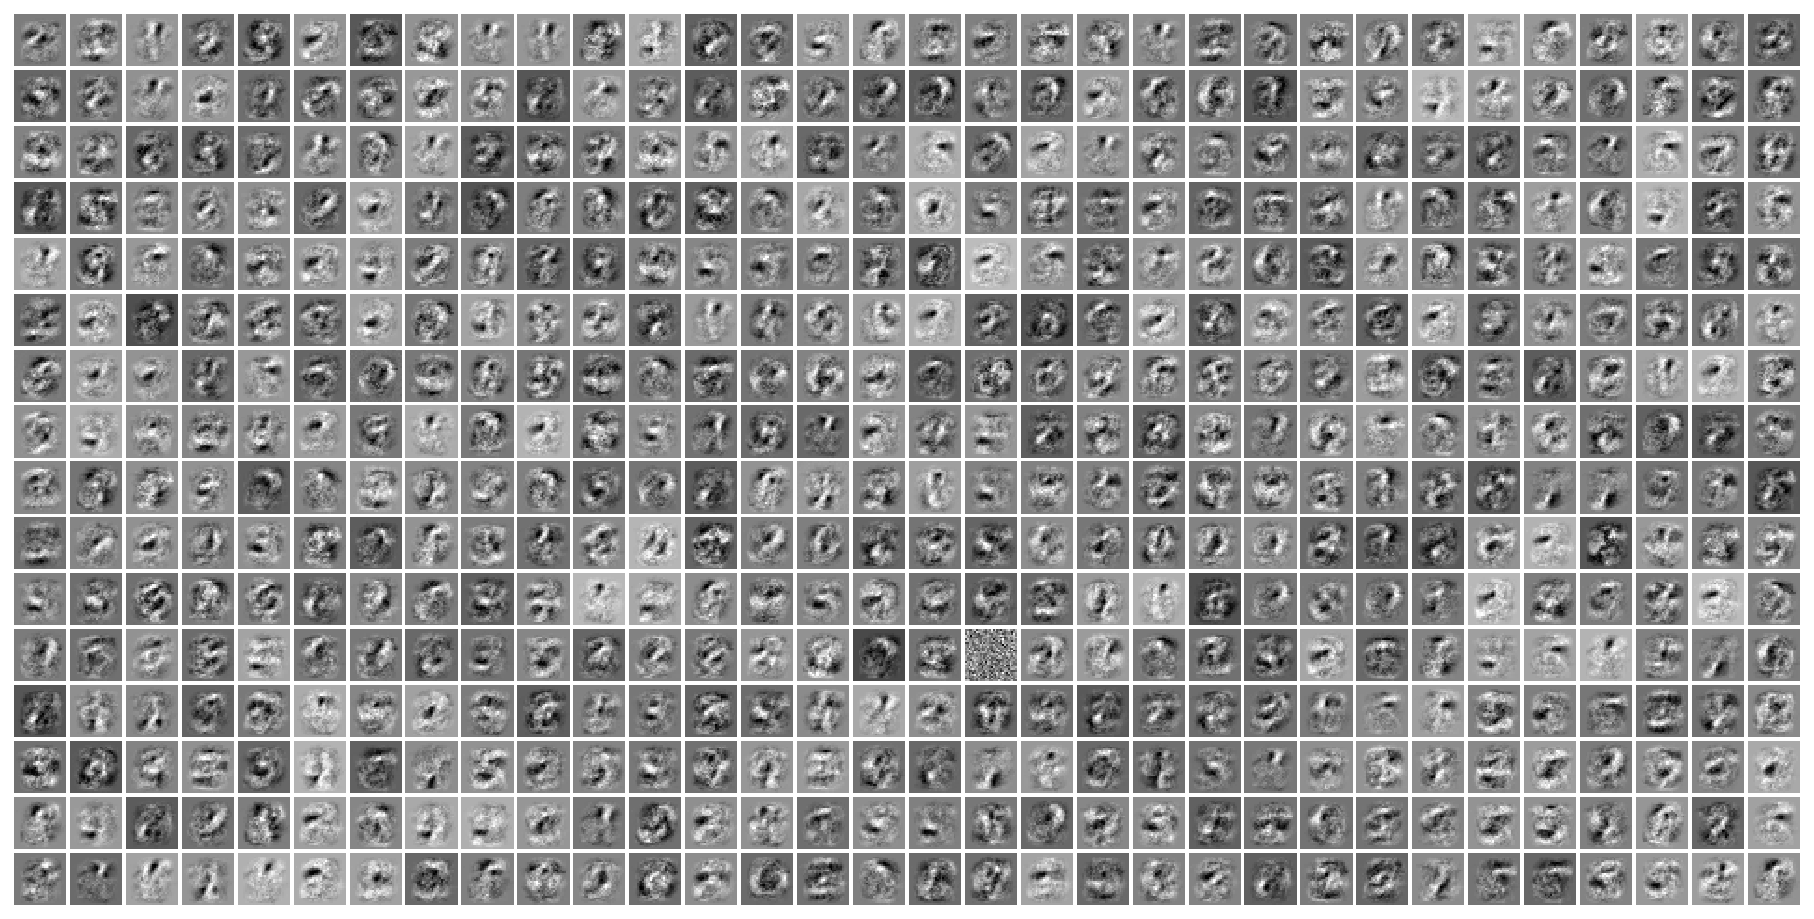

	layer 1: 1.00
	layer 2: 1.00
	layer 3: 4.00


In [18]:
mlp_with_dropout = [
    Layer(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.2, LEARNING_RATE, MOMENTUM,
          weight_limit=1.0),
    Layer(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, relu, relu_derivative, 0.5, LEARNING_RATE, MOMENTUM,
          weight_limit=1.0),
    Layer(HIDDEN_LAYER_SIZE, 10, softmax, None, 0.5, SOFTMAX_LEARNING_RATE, MOMENTUM,
          weight_limit=4.0)
]

evaluate(mlp_with_dropout, 
         mnist_train_images, mnist_train_labels, 
         mnist_test_images, mnist_test_labels,
         BATCH_SIZE, EPOCHS_COUNT)